In [1]:
import cython
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from CyRK import nb2cy, cyrk_ode, nbrk_ode

In [2]:
RTOL = 1.0e-7
ATOL = 1.0e-8

pendulum_y0 = np.asarray((0.01, 0.), dtype=np.float64)
pendulum_args = (1., 1., 9.81)  # length [m], mass [kg], acceleration due to gravity [m s-2]
pendulum_time_span_1 = (0., 10.)
pendulum_time_span_2 = (0., 100.)

@njit(cache=True)
def pendulum_nb(t, y, l, m, g):

    # External torque
    torque = 0.1 * np.sin(t)

    y0 = y[0]  # Angular deflection [rad]
    y1 = y[1]  # Angular velocity [rad s-1]
    dy = np.empty_like(y)
    dy[0] = y1
    dy[1] = (-3. * g / (2. * l)) * np.sin(y0) + (3. / (m * l**2)) * torque
    return dy


pendulum_cy = nb2cy(pendulum_nb, use_njit=True, cache_njit=True)

In [3]:
print('Working on Cython (function) integration...')
t_cy, y_cy, _, _ = cyrk_ode(pendulum_cy, pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1)
print(t_cy.size)
print('Done.')
print('Working on Numba integration...')
t_nb, y_nb, _, _ = nbrk_ode(pendulum_nb, pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1)
print('Done.')

Working on Cython (function) integration...
181
Done.
Working on Numba integration...
Done.


In [7]:
print('Performance')
print('Cython (function)')
# v0.5.3: 1.19ms, 1.2ms, 1.2ms
# v0.6.2: 1.02ms, 1.02ms
%timeit cyrk_ode(pendulum_cy, pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1)

print('\nNumba')
# v0.5.3: 199us, 201us, 200us
# v0.6.2: 187us, 188us
%timeit nbrk_ode(pendulum_nb, pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1)

Performance
Cython (function)
1.02 ms ± 5.82 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

Numba
188 µs ± 251 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


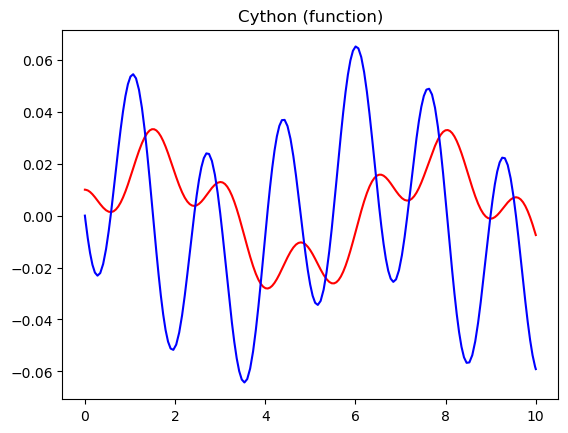

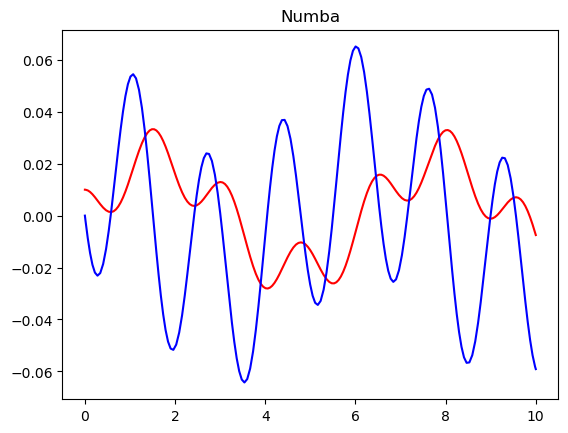

In [8]:
fig_cy, ax_cy = plt.subplots()
ax_cy.plot(t_cy, y_cy[0], 'r')
ax_cy.plot(t_cy, y_cy[1], 'b')
ax_cy.set(title='Cython (function)')
fig_nb, ax_nb = plt.subplots()
ax_nb.plot(t_nb, y_nb[0], 'r')
ax_nb.plot(t_nb, y_nb[1], 'b')
ax_nb.set(title='Numba')
plt.show()

In [9]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [17]:
%%cython --annotate --force
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION

import cython
import numpy as np
cimport numpy as np
np.import_array()
from libcpp cimport bool as bool_cpp_t
from libc.math cimport sqrt, fabs, nextafter, fmax, fmin, isnan, NAN

from CyRK.array.interp cimport interp_array
from CyRK.rk.rk cimport (
    RK23_C, RK23_B, RK23_E, RK23_A, RK23_order, RK23_error_order, RK23_n_stages, RK23_LEN_C, RK23_LEN_B, RK23_LEN_E,
    RK23_LEN_E3, RK23_LEN_E5, RK23_LEN_A0, RK23_LEN_A1,
    RK45_C, RK45_B, RK45_E, RK45_A, RK45_order, RK45_error_order, RK45_n_stages, RK45_LEN_C, RK45_LEN_B, RK45_LEN_E,
    RK45_LEN_E3, RK45_LEN_E5, RK45_LEN_A0, RK45_LEN_A1,
    DOP_C_REDUCED, DOP_B, DOP_E3, DOP_E5, DOP_A_REDUCED, DOP_order, DOP_error_order, DOP_n_stages,
    DOP_n_stages_extended, DOP_LEN_C, DOP_LEN_B, DOP_LEN_E, DOP_LEN_E3, DOP_LEN_E5, DOP_LEN_A0, DOP_LEN_A1)

# # Integration Constants
# Multiply steps computed from asymptotic behaviour of errors by this.
cdef double SAFETY = 0.9
cdef double MIN_FACTOR = 0.2  # Minimum allowed decrease in a step size.
cdef double MAX_FACTOR = 10.  # Maximum allowed increase in a step size.
cdef double MAX_STEP = np.inf
cdef double INF = np.inf
cdef double EPS = np.finfo(np.float64).eps
cdef double EPS_10 = EPS * 10.
cdef double EPS_100 = EPS * 100.

cdef (double, double) EMPTY_T_SPAN = (NAN, NAN)
    
cdef class CySolver:
    
    # Class attributes    
    # -- Live variables
    cdef double t_new, t_old
    cdef Py_ssize_t len_t
    cdef double[:] y_new_view, y_old_view, dy_new_view, dy_old_view
    cdef double[:] extra_output_view, extra_output_init_view
    
    # -- Dependent (y0) variable information
    cdef Py_ssize_t y_size
    cdef double y_size_dbl, y_size_sqrt
    cdef const double[:] y0_view
    
    # -- RK method information
    cdef unsigned char rk_method
    cdef unsigned char rk_order, error_order, rk_n_stages, rk_n_stages_plus1, rk_n_stages_extended
    cdef double error_expo
    cdef Py_ssize_t len_C
    cdef double[:] B_view, E_view, E3_view, E5_view, E_tmp_view, E3_tmp_view, E5_tmp_view, C_view
    cdef double[:, :] A_view, K_view
    
    # -- Integration information
    cdef public char status
    cdef public str message
    cdef public bool_cpp_t success
    cdef double t_start, t_end, t_delta, t_delta_abs, direction, direction_inf
    cdef double rtol, atol
    cdef double step_size, max_step
    cdef double first_step
    cdef Py_ssize_t expected_size
    cdef unsigned int num_concats
    
    # -- Optional args info
    cdef Py_ssize_t num_args
    cdef double[:] arg_array_view

    # -- Extra output info
    cdef bool_cpp_t capture_extra
    cdef Py_ssize_t num_extra

    # -- Interpolation info
    cdef bool_cpp_t run_interpolation
    cdef bool_cpp_t interpolate_extra
    cdef Py_ssize_t len_t_eval
    cdef double[:] t_eval_view

    # -- Solution variables
    cdef double[:, :] solution_y_view, solution_extra_view
    cdef double[:] solution_t_view
    
    def __init__(self,
                 (double, double) t_span,
                 const double[:] y0,
                 tuple args = None,
                 double rtol = 1.e-6,
                 double atol = 1.e-8,
                 double max_step = MAX_STEP,
                 double first_step = 0.,
                 unsigned char rk_method = 1,
                 const double[:] t_eval = None,
                 bool_cpp_t capture_extra = False,
                 Py_ssize_t num_extra = 0,
                 bool_cpp_t interpolate_extra = False,
                 unsigned int expected_size = 0,
                 bool_cpp_t auto_solve = True):
        
        # Setup loop variables
        cdef Py_ssize_t i, j

        # Set integration information
        self.status  = -3  # Status code to indicate that integration has not started.
        self.message = 'Integration has not started.'
        self.success = False

        # Declare public variables to avoid memory access violations if solve() is not called.
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] solution_extra_fake, solution_y_fake
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] solution_t_fake
        solution_extra_fake = np.nan * np.ones((1, 1), dtype=np.float64, order='C')
        solution_y_fake = np.nan * np.ones((1, 1), dtype=np.float64, order='C')
        solution_t_fake = np.nan * np.ones(1, dtype=np.float64, order='C')
        self.solution_t_view = solution_t_fake
        self.solution_extra_view = solution_extra_fake
        self.solution_y_view = solution_y_fake
        
        # Determine y-size information
        self.y_size = len(y0)
        self.y_size_dbl = <double>self.y_size
        self.y_size_sqrt = sqrt(self.y_size_dbl)
        # Store y0 values for later
        self.y0_view = y0
        
        # Determine time domain information
        self.t_start = t_span[0]
        self.t_end   = t_span[1]
        self.t_delta = self.t_end - self.t_start
        self.t_delta_abs = fabs(self.t_delta)
        if self.t_delta >= 0.:
            self.direction = 1.
        else:
            self.direction = -1.
        self.direction_inf = self.direction * INF

        # # Determine integration parameters
        # Add tolerances
        self.rtol = rtol
        self.atol = atol
        if self.rtol < EPS_100:
            self.rtol = EPS_100
        # TODO: array based atol
        #     atol_arr = np.asarray(atol, dtype=)
        #     if atol_arr.ndim > 0 and atol_arr.shape[0] != y_size:
        #         # atol must be either the same for all y or must be provided as an array, one for each y.
        #         raise Exception

        # Expected size of output arrays.
        cdef double temp_expected_size
        if expected_size == 0:
            # CySolver will attempt to guess on a best size for the arrays.
            temp_expected_size = 100. * self.t_delta_abs * fmax(1., (1.e-6 / rtol))
            temp_expected_size = fmax(temp_expected_size, 100.)
            temp_expected_size = fmin(temp_expected_size, 10_000_000.)
            self.expected_size = <Py_ssize_t>temp_expected_size
        else:
            self.expected_size = expected_size
        # This variable tracks how many times the storage arrays have been appended.
        # It starts at 1 since there is at least one storage array present.
        self.num_concats = 1
        
        # Determine optional arguments
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] arg_array
        if args is None:
            self.num_args = 0
            # Even though there are no args, initialize the array to something to avoid seg faults
            arg_array = np.empty(0, dype=np.float64, order='C')
            self.arg_array_view = arg_array
        else:
            self.num_args = len(args)
            arg_array = np.empty(self.num_args, dtype=np.float64, order='C')
            self.arg_array_view = arg_array
            for i in range(self.num_args):
                self.arg_array_view[i] = args[i]

        # Initialize live variable arrays
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] y_new, y_old, dy_new, dy_old
        y_new  = np.empty(self.y_size, dtype=np.float64, order='C')
        y_old  = np.empty(self.y_size, dtype=np.float64, order='C')
        dy_new = np.empty(self.y_size, dtype=np.float64, order='C')
        dy_old = np.empty(self.y_size, dtype=np.float64, order='C')
        self.y_new_view  = y_new
        self.y_old_view  = y_old
        self.dy_new_view = dy_new
        self.dy_old_view = dy_old
        
        # Set current and old y variables equal to y0
        for i in range(self.y_size):
            self.y_new_view[i] = self.y0_view[i]
            self.y_old_view[i] = self.y0_view[i]
            
        # Set current and old time variables equal to t0
        self.t_old = self.t_start
        self.t_new = self.t_start
        # We already have one time step due to the initial conditions.
        self.len_t = 1

        # Determine extra outputs
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] extra_output_init, extra_output
        self.capture_extra = capture_extra
        self.num_extra     = num_extra
        if self.capture_extra:
            extra_output_init = np.empty(self.num_extra, dtype=np.float64, order='C')
            extra_output      = np.empty(self.num_extra, dtype=np.float64, order='C')
            self.extra_output_init_view = extra_output_init
            self.extra_output_view      = extra_output

            # We need to determine the extra outputs at the initial time step. 
            self.diffeq()
            for i in range(num_extra):
                self.extra_output_init_view[i] = self.extra_output_view[i]
        
        # Determine interpolation information
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] t_eval_array
        if t_eval is None:
            self.run_interpolation = False
            self.interpolate_extra = False
            self.len_t_eval = 0
        else:
            self.run_interpolation = True
            self.interpolate_extra = interpolate_extra
            self.len_t_eval = len(t_eval)

            t_eval_array = np.empty(self.len_t_eval, dtype=np.float64, order='C')
            self.t_eval_view = t_eval_array
            for i in range(self.len_t_eval):
                self.t_eval_view[i] = t_eval[i]
        
        # Determine RK scheme
        self.rk_method = rk_method
        cdef Py_ssize_t len_B, len_E, len_E3, len_E5, len_A0, len_A1
        # Note, len_C is used during the solving phase so it is declared at the class level.

        if rk_method == 0:
            # RK23 Method
            self.rk_order    = RK23_order
            self.error_order = RK23_error_order
            self.rk_n_stages = RK23_n_stages
            self.len_C       = RK23_LEN_C
            len_B            = RK23_LEN_B
            len_E            = RK23_LEN_E
            len_E3           = RK23_LEN_E3
            len_E5           = RK23_LEN_E5
            len_A0           = RK23_LEN_A0
            len_A1           = RK23_LEN_A1
        elif rk_method == 1:
            # RK45 Method
            self.rk_order    = RK45_order
            self.error_order = RK45_error_order
            self.rk_n_stages = RK45_n_stages
            self.len_C       = RK45_LEN_C
            len_B            = RK45_LEN_B
            len_E            = RK45_LEN_E
            len_E3           = RK45_LEN_E3
            len_E5           = RK45_LEN_E5
            len_A0           = RK45_LEN_A0
            len_A1           = RK45_LEN_A1
        elif rk_method == 2:
            # DOP853 Method
            self.rk_order    = DOP_order
            self.error_order = DOP_error_order
            self.rk_n_stages = DOP_n_stages
            self.len_C       = DOP_LEN_C
            len_B            = DOP_LEN_B
            len_E            = DOP_LEN_E
            len_E3           = DOP_LEN_E3
            len_E5           = DOP_LEN_E5
            len_A0           = DOP_LEN_A0
            len_A1           = DOP_LEN_A1

            self.rk_n_stages_extended = DOP_n_stages_extended
        else:
            raise AttributeError(
                'Unexpected rk_method provided. Currently supported versions are:\n'
                '\t0 = RK23\n'
                '\t1 = RK34\n'
                '\t2 = DOP853')

        self.rk_n_stages_plus1 = self.rk_n_stages + 1
        self.error_expo        = 1. / (<double>self.error_order + 1.)

        # Initialize RK Arrays. Note that all are 1D except for A and K.
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] A, K
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] B, C, E, E3, E5, E_tmp, E3_tmp, E5_tmp
        
        A      = np.empty((len_A0, len_A1), dtype=np.float64, order='C')
        B      = np.empty(len_B, dtype=np.float64, order='C')
        C      = np.empty(self.len_C, dtype=np.float64, order='C')
        E      = np.empty(len_E, dtype=np.float64, order='C')
        E3     = np.empty(len_E3, dtype=np.float64, order='C')
        E5     = np.empty(len_E5, dtype=np.float64, order='C')
        E_tmp  = np.empty(self.y_size, dtype=np.float64, order='C')
        E3_tmp = np.empty(self.y_size, dtype=np.float64, order='C')
        E5_tmp = np.empty(self.y_size, dtype=np.float64, order='C')
        # It is important K be initialized with 0s
        K      = np.zeros((self.rk_n_stages_plus1, self.y_size), dtype=np.float64, order='C')

        # Setup memory views.
        self.A_view      = A
        self.B_view      = B
        self.C_view      = C
        self.E_view      = E
        self.E3_view     = E3
        self.E5_view     = E5
        self.E_tmp_view  = E_tmp
        self.E3_tmp_view = E3_tmp
        self.E5_tmp_view = E5_tmp
        self.K_view      = K
        
        # Populate values based on externally defined constants.
        if rk_method == 0:
            # RK23 Method
            for i in range(len_A0):
                for j in range(len_A1):
                    self.A_view[i, j] = RK23_A[i][j]
            for i in range(len_B):
                self.B_view[i] = RK23_B[i]
            for i in range(self.len_C):
                self.C_view[i] = RK23_C[i]
            for i in range(len_E):
                self.E_view[i] = RK23_E[i]
                # Dummy Variables, set equal to E
                self.E3_view[i] = RK23_E[i]
                self.E5_view[i] = RK23_E[i]
        elif rk_method == 1:
            # RK45 Method
            for i in range(len_A0):
                for j in range(len_A1):
                    self.A_view[i, j] = RK45_A[i][j]
            for i in range(len_B):
                self.B_view[i] = RK45_B[i]
            for i in range(self.len_C):
                self.C_view[i] = RK45_C[i]
            for i in range(len_E):
                self.E_view[i] = RK45_E[i]
                # Dummy Variables, set equal to E
                self.E3_view[i] = RK45_E[i]
                self.E5_view[i] = RK45_E[i]
        else:
            # DOP853 Method
            for i in range(len_A0):
                for j in range(len_A1):
                    self.A_view[i, j] = DOP_A_REDUCED[i][j]
            for i in range(len_B):
                self.B_view[i] = DOP_B[i]
            for i in range(self.len_C):
                self.C_view[i] = DOP_C_REDUCED[i]
            for i in range(len_E):
                self.E3_view[i] = DOP_E3[i]
                self.E5_view[i] = DOP_E5[i]
                self.E_view[i] = DOP_E5[i]
                # Dummy Variables, set equal to E3
                self.E_view[i] = DOP_E3[i]

        # Initialize dy_new_view for start of integration (important for first_step calculation)
        if not self.capture_extra:
            # If `capture_extra` is True then this step was already performed so we can skip it.
            self.diffeq()
        
        for i in range(self.y_size):
            self.dy_old_view[i] = self.dy_new_view[i]

        # Determine first step
        self.first_step = first_step
        if self.first_step == 0.:
            self.step_size = self.calc_first_step()
        else:
            if self.first_step <= 0.:
                raise AttributeError('Error in user-provided step size: Step size must be a positive number.')
            elif self.first_step > self.t_delta_abs:
                raise AttributeError('Error in user-provided step size: Step size can not exceed bounds.')
            self.step_size = self.first_step
        self.max_step = max_step

        # Run solver if requested
        if auto_solve:
            # We know for a fact that this is the first time solve will be called
            #  so we do not need to reset the state.
            self._solve(reset=False)


    cpdef void reset_state(self):
        """ Resets the integrator to its initial state. """
        cdef Py_ssize_t i, j

        # Set current and old time variables equal to t0
        self.t_old = self.t_start
        self.t_new = self.t_start
        self.len_t = 1

        # Reset y variables
        for i in range(self.y_size):
            # Set current and old y variables equal to y0
            self.y_new_view[i] = self.y0_view[i]
            self.y_old_view[i] = self.y0_view[i]

            for j in range(self.rk_n_stages_plus1):
                # Reset RK variables
                self.K_view[j, i] = 0.

        # Make initial call to diffeq()
        self.diffeq()
        for i in range(self.y_size):
            self.dy_old_view[i] = self.dy_new_view[i]

        # Determine first step size
        if self.first_step == 0.:
            self.step_size = self.calc_first_step()
        else:
            if self.first_step <= 0.:
                raise AttributeError('Error in user-provided step size: Step size must be a positive number.')
            elif self.first_step > self.t_delta_abs:
                raise AttributeError('Error in user-provided step size: Step size can not exceed bounds.')
            self.step_size = self.first_step

        # Reset output storage
        self.num_concats = 1

        # Reset public variables to clear any old solutions.
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] solution_extra_fake, solution_y_fake
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] solution_t_fake
        solution_extra_fake = np.nan * np.ones((1, 1), dtype=np.float64, order='C')
        solution_y_fake = np.nan * np.ones((1, 1), dtype=np.float64, order='C')
        solution_t_fake = np.nan * np.ones(1, dtype=np.float64, order='C')
        self.solution_t_view = solution_t_fake
        self.solution_extra_view = solution_extra_fake
        self.solution_y_view = solution_y_fake

        # Other flags and messages
        self.success = False
        self.status = -5  # status == -5 means that reset has been called but solve has not yet been called.
        self.message = "CySolver has been reset."


    @cython.exceptval(check=False)
    cdef double calc_first_step(self):
        """ Determine initial step size. """
        
        cdef double step_size, d0, d1, d2, d0_abs, d1_abs, d2_abs, h0, h1, scale

        # Select an initial step size based on the differential equation.
        # .. [1] E. Hairer, S. P. Norsett G. Wanner, "Solving Ordinary Differential
        #        Equations I: Nonstiff Problems", Sec. II.4.
        if self.y_size == 0:
            step_size = INF
        else:
            # Find the norm for d0 and d1
            d0 = 0.
            d1 = 0.
            for i in range(self.y_size):
                scale = self.atol + fabs(self.y_old_view[i]) * self.rtol

                d0_abs = fabs(self.y_old_view[i] / scale)
                d1_abs = fabs(self.dy_old_view[i] / scale)
                d0 += (d0_abs * d0_abs)
                d1 += (d1_abs * d1_abs)

            d0 = sqrt(d0) / self.y_size_sqrt
            d1 = sqrt(d1) / self.y_size_sqrt

            if d0 < 1.e-5 or d1 < 1.e-5:
                h0 = 1.e-6
            else:
                h0 = 0.01 * d0 / d1

            h0_direction = h0 * self.direction
            self.t_new = self.t_old + h0_direction
            for i in range(self.y_size):
                self.y_new_view[i] = self.y_old_view[i] + h0_direction * self.dy_old_view[i]
            
            # Update dy_new_view
            self.diffeq()

            # Find the norm for d2
            d2 = 0.
            for i in range(self.y_size):
                scale = self.atol + fabs(self.y_old_view[i]) * self.rtol
                d2_abs = fabs( (self.dy_new_view[i] - self.dy_old_view[i]) / scale)
                d2 += (d2_abs * d2_abs)

            d2 = sqrt(d2) / (h0 * self.y_size_sqrt)

            if d1 <= 1.e-15 and d2 <= 1.e-15:
                h1 = max(1.e-6, h0 * 1.e-3)
            else:
                h1 = (0.01 / max(d1, d2))**self.error_expo

            step_size = max(10. * fabs(nextafter(self.t_old, self.direction_inf) - self.t_old),
                            min(100. * h0, h1))
            
        return step_size


    @cython.exceptval(check=False)
    cpdef void solve(self, bool_cpp_t reset = True):
        self._solve()


    @cython.exceptval(check=False)
    cdef void _solve(self, bool_cpp_t reset = True):
        """ Perform Runge-Kutta integration on `self.diffeq` function."""

        # Reset the solver's state (avoid issues if solve() is called multiple times).
        if reset:
            self.reset_state()

        # Setup loop variables
        cdef Py_ssize_t s, i, j
        
        # Initialize other variables
        cdef double error_norm5, error_norm3, error_norm, error_norm_abs, error_norm3_abs, error_norm5_abs, error_denom, error_pow
        
        # Avoid method lookups for variables in tight loops
        cdef double[:] B_view, E_view, E3_view, E5_view, E_tmp_view, E3_tmp_view, E5_tmp_view, C_view
        cdef double[:, :] A_view, K_view
        A_view      = self.A_view
        B_view      = self.B_view
        C_view      = self.C_view
        E_view      = self.E_view
        E3_view     = self.E3_view
        E5_view     = self.E5_view
        E_tmp_view  = self.E_tmp_view
        E3_tmp_view = self.E3_tmp_view
        E5_tmp_view = self.E5_tmp_view
        K_view      = self.K_view
        
        # Setup storage arrays
        # These arrays are built to fit a number of points equal to `self.expected_size`
        # If the integration needs more than that then a new array will be concatenated (with performance costs) to these.
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] y_results_array, extra_array
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] time_domain_array
        cdef double[:, :] y_results_array_view, extra_array_view
        cdef double[:] time_domain_array_view
        y_results_array        = np.empty((self.y_size, self.expected_size), dtype=np.float64, order='C')
        time_domain_array      = np.empty(self.expected_size, dtype=np.float64, order='C')
        y_results_array_view   = y_results_array
        time_domain_array_view = time_domain_array
        if self.capture_extra:
            extra_array      = np.empty((self.num_extra, self.expected_size), dtype=np.float64, order='C')
            extra_array_view = extra_array

        # The following are unused unless the previous array size is too small to capture all of the data
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] y_results_array_new, extra_array_new
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] time_domain_array_new
        cdef double[:, :] y_results_array_new_view, extra_array_new_view
        cdef double[:] time_domain_array_new_view
        
        # Load initial conditions into output arrays
        time_domain_array_view[0] = self.t_start
        for i in range(self.y_size):
            y_results_array_view[i, 0] = self.y0_view[i]
        if self.capture_extra:
            for i in range(self.num_extra):
                extra_array_view[i, 0] = self.extra_output_init_view[i]

        # Reset live variables to their starting values.
        # Set current and old y variables equal to y0
        for i in range(self.y_size):
            self.y_new_view[i] = self.y0_view[i]
            self.y_old_view[i] = self.y0_view[i]
        # Set current and old time variables equal to t0
        self.t_old = self.t_start
        self.t_new = self.t_start
        
        # Set integration flags
        cdef bool_cpp_t step_accepted, step_rejected, step_error
        self.success  = False
        step_accepted = False
        step_rejected = False
        step_error    = False
        
        # # Main integration loop
        cdef double min_step, step_factor, step, time_tmp
        cdef double c
        cdef double K_scale
        # Integrator Status Codes
        #   0  = Running
        #   -1 = Failed (step size too small)
        #   -2 = Failed (step size failed to converge)
        #   -3 = Integration has not started yet.
        #   1  = Finished with no obvious issues
        self.message = 'Integrator is running.'
        self.status  = 0
        # There is an initial condition provided so the time length is already 1
        self.len_t = 1
        
        while self.status == 0:
            if self.t_new == self.t_end or self.y_size == 0:
                self.t_old = self.t_end
                self.t_new = self.t_end
                self.status = 1
                break

            # Run RK integration step
            # Determine step size based on previous loop
            # Find minimum step size based on the value of t (less floating point numbers between numbers when t is large)
            min_step = 10. * fabs(nextafter(self.t_old, self.direction_inf) - self.t_old)
            # Look for over/undershoots in previous step size
            if self.step_size > self.max_step:
                self.step_size = self.max_step
            elif self.step_size < min_step:
                self.step_size = min_step

            # Determine new step size
            step_accepted = False
            step_rejected = False
            step_error    = False

            # # Step Loop
            while not step_accepted:

                if self.step_size < min_step:
                    step_error  = True
                    self.status = -1
                    break

                # Move time forward for this particular step size
                step = self.step_size * self.direction
                self.t_new = self.t_old + step

                # Check that we are not at the end of integration with that move
                if self.direction * (self.t_new - self.t_end) > 0.:
                    self.t_new = self.t_end

                    # Correct the step if we were at the end of integration
                    step = self.t_new - self.t_old
                    self.step_size = fabs(step)

                # Calculate derivative using RK method
                for i in range(self.y_size):
                    K_view[0, i] = self.dy_old_view[i]

                # t_new must be updated for each loop of s in order to make the diffeq calls. 
                # But we need to return to its original value later on. Store in temp variable.
                time_tmp = self.t_new
                for s in range(1, self.len_C):
                    c = C_view[s]
                    
                    # Update t_new so it can be used in the diffeq call.
                    self.t_new = self.t_old + c * step

                    # Dot Product (K, a) * step
                    for j in range(s):
                        for i in range(self.y_size):
                            if j == 0:
                                # Initialize
                                self.y_new_view[i] = self.y_old_view[i]

                            self.y_new_view[i] = self.y_new_view[i] + (K_view[j, i] * A_view[s, j] * step)
                    
                    self.diffeq()

                    for i in range(self.y_size):
                        K_view[s, i] = self.dy_new_view[i]
                
                # Restore t_new to its previous value.
                self.t_new = time_tmp

                # Dot Product (K, B) * step
                for j in range(self.rk_n_stages):
                    # We do not use rk_n_stages_plus1 here because we are chopping off the last row of K to match
                    #  the shape of B.
                    for i in range(self.y_size):
                        if j == 0:
                            # Initialize
                            self.y_new_view[i] = self.y_old_view[i]
                        self.y_new_view[i] = self.y_new_view[i] + (K_view[j, i] * B_view[j] * step)
                
                self.diffeq()

                if self.rk_method == 2:
                    # Calculate Error for DOP853

                    # Dot Product (K, E5) / scale and Dot Product (K, E3) * step / scale
                    for i in range(self.y_size):
                        # Check how well this step performed.
                        scale = self.atol + max(fabs(self.y_old_view[i]), fabs(self.y_new_view[i])) * self.rtol

                        for j in range(self.rk_n_stages_plus1):
                            if j == 0:
                                # Initialize
                                E5_tmp_view[i] = 0.
                                E3_tmp_view[i] = 0.

                            elif j == self.rk_n_stages:
                                # Set last array of the K array.
                                K_view[j, i] = self.dy_new_view[i]

                            K_scale = K_view[j, i] / scale
                            E5_tmp_view[i] = E5_tmp_view[i] + (K_scale * E5_view[j])
                            E3_tmp_view[i] = E3_tmp_view[i] + (K_scale * E3_view[j])

                    # Find norms for each error
                    error_norm5 = 0.
                    error_norm3 = 0.

                    # Perform summation
                    for i in range(self.y_size):
                        error_norm5_abs = fabs(E5_tmp_view[i])
                        error_norm3_abs = fabs(E3_tmp_view[i])

                        error_norm5 += (error_norm5_abs * error_norm5_abs)
                        error_norm3 += (error_norm3_abs * error_norm3_abs)

                    # Check if errors are zero
                    if (error_norm5 == 0.) and (error_norm3 == 0.):
                        error_norm = 0.
                    else:
                        error_denom = error_norm5 + 0.01 * error_norm3
                        error_norm = self.step_size * error_norm5 / sqrt(error_denom * self.y_size_dbl)

                else:
                    # Calculate Error for RK23 and RK45
                    error_norm = 0.
                    # Dot Product (K, E) * step / scale
                    for i in range(self.y_size):

                        # Check how well this step performed.
                        scale = self.atol + max(fabs(self.y_old_view[i]), fabs(self.y_new_view[i])) * self.rtol

                        for j in range(self.rk_n_stages_plus1):
                            if j == 0:
                                # Initialize
                                E_tmp_view[i] = 0.
                            elif j == self.rk_n_stages:
                                # Set last array of the K array.
                                K_view[j, i] = self.dy_new_view[i]

                            K_scale = self.K_view[j, i] / scale
                            E_tmp_view[i] = E_tmp_view[i] + (K_scale * E_view[j] * step)

                        error_norm_abs = fabs(E_tmp_view[i])
                        error_norm += (error_norm_abs * error_norm_abs)
                    error_norm = sqrt(error_norm) / self.y_size_sqrt

                if error_norm < 1.:
                    # The error is low! Let's update this step for the next time loop
                    if error_norm == 0.:
                        step_factor = MAX_FACTOR
                    else:
                        error_pow = error_norm**-self.error_expo
                        step_factor = min(MAX_FACTOR, SAFETY * error_pow)

                    if step_rejected:
                        # There were problems with this step size on the previous step loop. Make sure factor does
                        #    not exasperate them.
                        step_factor = min(step_factor, 1.)

                    self.step_size = self.step_size * step_factor
                    step_accepted = True
                else:
                    error_pow = error_norm**-self.error_expo
                    self.step_size = self.step_size * max(MIN_FACTOR, SAFETY * error_pow)
                    step_rejected = True

           
            if step_error:
                # Issue with step convergence
                self.status = -1
                break
            elif not step_accepted:
                # Issue with step convergence
                self.status = -2
                break

            # End of step loop. Update the _now variables
            self.t_old = self.t_new
            for i in range(self.y_size):
                self.y_old_view[i] = self.y_new_view[i]
                self.dy_old_view[i] = self.dy_new_view[i]

            # Save data
            if self.len_t >= (self.num_concats * self.expected_size):                
                # There is more data than we have room in our arrays. 
                # Build new arrays with more space.
                # OPT: Note this is an expensive operation. 
                self.num_concats += 1
                new_size = self.num_concats * self.expected_size
                time_domain_array_new = np.empty(new_size, dtype=np.float64, order='C')
                y_results_array_new = np.empty((self.y_size, new_size), dtype=np.float64, order='C')
                time_domain_array_new_view = time_domain_array_new
                y_results_array_new_view = y_results_array_new
                if self.capture_extra:
                    extra_array_new = np.empty((self.num_extra, new_size), dtype=np.float64, order='C')
                    extra_array_new_view = extra_array_new

                # Loop through time to fill in these new arrays with the old values
                for i in range(self.len_t):
                    time_domain_array_new_view[i] = time_domain_array_view[i]

                    for j in range(self.y_size):
                        y_results_array_new_view[j, i] = y_results_array_view[j, i]
                    
                    if self.capture_extra:
                        for j in range(self.num_extra):
                            extra_array_new_view[j, i] = extra_array_view[j, i]
                
                # No longer need the old arrays. Change where the view is pointing and delete them.
                y_results_array_view = y_results_array_new
                time_domain_array_view = time_domain_array_new
                # TODO: Delete the old arrays?
                if self.capture_extra:
                    extra_array_view = extra_array_new
            
            # There should be room in the arrays to add new data.
            time_domain_array_view[self.len_t] = self.t_new
            # To match the format that scipy follows, we will take the transpose of y.
            for i in range(self.y_size):
                y_results_array_view[i, self.len_t] = self.y_new_view[i]
            
            if self.capture_extra:
                for i in range(self.num_extra):
                    extra_array_view[i, self.len_t] = self.extra_output_view[i]

            # Increase number of time points.
            self.len_t += 1

        # # Clean up output.
        self.message = 'Integration completed.'
        if self.status == 1:
            self.success = True
            self.message = 'Integration finished with no issue.'
        elif self.status == -1:
            self.message = 'Integration Failed: Error in step size calculation: Required step size is less than spacing between numbers.'
        elif self.status == -2:
            # Don't think this should ever come up.
            self.message = 'Integration Failed: Other issue with step size.'
        elif self.status == -3:
            # Don't think this should ever come up.
            self.message = 'Integration never started.'
        elif self.status < -3:
            self.message = 'Integration Failed.'

        # Create output arrays. To match the format that scipy follows, we will take the transpose of y.
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] y_results_out_array, y_results_out_array_bad
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] extra_output_out_array, extra_output_out_array_bad
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] time_domain_out_array, time_domain_out_array_bad

        if self.success:
            # Build final output arrays.
            # The arrays built during integration likely have a bunch of unused junk at the end due to overbuilding their size.
            # This process will remove that junk and leave only the wanted data.
            y_results_out_array = np.empty((self.y_size, self.len_t), dtype=np.float64, order='C')
            time_domain_out_array = np.empty(self.len_t, dtype=np.float64, order='C')
            if self.capture_extra:
                extra_output_out_array = np.empty((self.num_extra, self.len_t), dtype=np.float64, order='C')

            # Link memory views
            self.solution_y_view = y_results_out_array
            self.solution_t_view = time_domain_out_array
            if self.capture_extra:
                self.solution_extra_view = extra_output_out_array

            # Populate values
            for i in range(self.len_t):
                self.solution_t_view[i] = time_domain_array_view[i]
                for j in range(self.y_size):
                    self.solution_y_view[j, i] = y_results_array_view[j, i]
                if self.capture_extra:
                    for j in range(self.num_extra):
                        self.solution_extra_view[j, i] = extra_array_view[j, i]
        else:
            # Build nan arrays
            y_results_out_array_bad = np.nan * np.ones((self.y_size, 1), dtype=np.float64, order='C')
            time_domain_out_array_bad = np.nan * np.ones(1, dtype=np.float64, order='C')
            if self.capture_extra:
                extra_output_out_array_bad = np.nan * np.ones((self.num_extra, 1), dtype=np.float64, order='C')

            # Link memory views
            self.solution_y_view = y_results_out_array_bad
            self.solution_t_view = time_domain_out_array_bad
            if self.capture_extra:
                self.solution_extra_view = extra_output_out_array_bad

        # Integration is complete. Check if interpolation was requested.
        if self.success and self.run_interpolation:
            self.interpolate()


    @cython.exceptval(check=False)
    cdef void interpolate(self):
        """ Interpolate the results of a successful integration over the user provided time domain, `t_eval`."""
        # User only wants data at specific points.

        # Setup loop variables
        cdef Py_ssize_t i, j

        # The current version of this function has not implemented sicpy's dense output.
        #   Instead we use an interpolation.
        # OPT: this could be done inside the integration loop for performance gains.
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] y_results_reduced
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] y_result_timeslice, y_result_temp
        y_results_reduced  = np.empty((self.y_size, self.len_t_eval), dtype=np.float64, order='C')
        y_result_timeslice = np.empty(self.len_t, dtype=np.float64, order='C')
        y_result_temp      = np.empty(self.len_t_eval, dtype=np.float64, order='C')

        cdef double[:, :] y_results_reduced_view
        cdef double[:] y_result_timeslice_view, y_result_temp_view
        y_results_reduced_view  = y_results_reduced
        y_result_timeslice_view = y_result_timeslice
        y_result_temp_view      = y_result_temp

        # Create arrays for extra output which may or may not be required.
        cdef np.ndarray[np.float64_t, ndim=2, mode='c'] extra_reduced
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] extra_timeslice, extra_temp
        cdef double[:, :] extra_reduced_view
        cdef double[:] extra_timeslice_view, extra_temp_view

        for j in range(self.y_size):
            # np.interp only works on 1D arrays so we must loop through each of the y variables.

            # # Set timeslice equal to the time values at this y_j
            for i in range(self.len_t):
                y_result_timeslice_view[i] = self.solution_y_view[j, i]

            # Perform numerical interpolation
            interp_array(
                self.t_eval_view,
                self.solution_t_view,
                y_result_timeslice_view,
                y_result_temp_view
                )

            # Store result.
            for i in range(self.len_t_eval):
                y_results_reduced_view[j, i] = y_result_temp_view[i]

        if self.capture_extra:
            # Right now if there is any extra output then it is stored at each time step used in the RK loop.
            # We have to make a choice on what to output do we, like we do with y, interpolate all of those extras?
            #  or do we use the interpolation on y to find new values.
            # The latter method is more computationally expensive (recalls the diffeq for each y) but is more accurate.

            # Create extra output arrays
            extra_reduced   = np.empty((self.num_extra, self.len_t_eval), dtype=np.float64, order='C')
            extra_timeslice = np.empty(self.len_t, dtype=np.float64, order='C')
            extra_temp      = np.empty(self.len_t_eval, dtype=np.float64, order='C')
            extra_reduced_view   = extra_reduced
            extra_timeslice_view = extra_timeslice
            extra_temp_view      = extra_temp

            if self.interpolate_extra:
                # Continue the interpolation for the extra values.
                for j in range(self.num_extra):
                    # np.interp only works on 1D arrays so we must loop through each of the variables:
                    # # Set timeslice equal to the time values at this y_j
                    for i in range(self.len_t):
                        extra_timeslice_view[i] = self.solution_extra_view[j, i]

                    # Perform numerical interpolation
                    interp_array(
                            self.t_eval_view,
                            self.solution_t_view,
                            extra_timeslice_view,
                            extra_temp_view
                            )

                    # Store result.
                    for i in range(self.len_t_eval):
                        extra_reduced_view[j, i] = extra_temp_view[i]
            else:
                # Use y and t to recalculate the extra outputs with self.diffeq
                for i in range(self.len_t_eval):
                    # Set state variables
                    self.t_new = self.t_eval_view[i]
                    for j in range(self.y_size):
                        self.y_new_view[j] = y_results_reduced_view[j, i]
                    
                    # Call diffeq to recalculate extra outputs
                    self.diffeq()

                    # Capture extras
                    for j in range(self.num_extra):
                        extra_reduced_view[j, i] = self.extra_output_view[j]

        # Replace the solution variables with the new interpolated ones
        self.solution_t_view = self.t_eval_view
        self.solution_y_view = y_results_reduced_view
        if self.capture_extra:
            self.solution_extra_view = extra_reduced_view


    cpdef void change_t_span(self, (double, double) t_span, bool_cpp_t auto_reset_state = False):

        # Update time domain information
        self.t_start     = t_span[0]
        self.t_end       = t_span[1]
        self.t_delta     = self.t_end - self.t_start
        self.t_delta_abs = fabs(self.t_delta)
        if self.t_delta >= 0.:
            self.direction = 1.
        else:
            self.direction = -1.
        self.direction_inf = self.direction * INF

        if auto_reset_state:
            self.reset_state()


    cpdef void change_y0(self, const double[:] y0, bool_cpp_t auto_reset_state = False):

        # Check y-size information
        cdef Py_ssize_t y_size_new
        y_size_new = len(y0)

        if self.y_size != y_size_new:
            # So many things need to update if ysize changes that the user might as well just
            #  create a new class instance.
            self.status = -6  # Bad update status
            raise AttributeError('New y0 must be the same size as the original y0 used to create CySolver class.'
                                 'Create new CySolver instance instead.')

        # Store y0 values for later
        self.y0_view = y0

        if auto_reset_state:
            self.reset_state()


    cpdef void change_args(self, tuple args, bool_cpp_t auto_reset_state = False):

        # Determine optional arguments
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] arg_array

        self.num_args = len(args)
        arg_array = np.empty(self.num_args, dtype=np.float64, order='C')
        self.arg_array_view = arg_array
        for i in range(self.num_args):
            self.arg_array_view[i] = args[i]

        if auto_reset_state:
            self.reset_state()


    cpdef void change_tols(self, double rtol = NAN, double atol = NAN, bool_cpp_t auto_reset_state = False):

        # Update tolerances
        if not isnan(rtol):
            self.rtol = rtol
        if not isnan(atol):
            self.atol = atol

        if self.rtol < EPS_100:
            self.rtol = EPS_100
        # TODO: array based atol
        #     atol_arr = np.asarray(atol, dtype=)
        #     if atol_arr.ndim > 0 and atol_arr.shape[0] != y_size:
        #         # atol must be either the same for all y or must be provided as an array, one for each y.
        #         raise Exception

        if auto_reset_state:
            self.reset_state()


    cpdef void change_max_step(self, double max_step, bool_cpp_t auto_reset_state = False):

        self.max_step = max_step

        if auto_reset_state:
            self.reset_state()


    cpdef void change_first_step(self, double first_step, bool_cpp_t auto_reset_state = False):

        self.first_step = first_step
        if self.first_step == 0.:
            self.step_size = self.calc_first_step()
        else:
            if self.first_step <= 0.:
                raise AttributeError('Error in user-provided step size: Step size must be a positive number.')
            elif self.first_step > self.t_delta_abs:
                raise AttributeError('Error in user-provided step size: Step size can not exceed bounds.')
            self.step_size = self.first_step

        if auto_reset_state:
            self.reset_state()


    cpdef void change_t_eval(self, const double[:] t_eval, bool_cpp_t auto_reset_state = False):

        # Determine interpolation information
        cdef np.ndarray[np.float64_t, ndim=1, mode='c'] t_eval_array

        self.run_interpolation = True
        self.len_t_eval = len(t_eval)

        t_eval_array = np.empty(self.len_t_eval, dtype=np.float64, order='C')
        self.t_eval_view = t_eval_array
        for i in range(self.len_t_eval):
            self.t_eval_view[i] = t_eval[i]

        if auto_reset_state:
            self.reset_state()


    cpdef void change_parameters(
            self,
            (double, double) t_span = EMPTY_T_SPAN,
            const double[:] y0 = None,
            tuple args = None,
            double rtol = NAN,
            double atol = NAN,
            double max_step = NAN,
            double first_step = NAN,
            const double[:] t_eval = None,
            bool_cpp_t auto_reset_state = True,
            bool_cpp_t auto_solve = False):

        if not isnan(t_span[0]):
            self.change_t_span(t_span, auto_reset_state=False)

        if y0 is not None:
            self.change_y0(y0, auto_reset_state=False)

        if args is not None:
            self.change_args(args, auto_reset_state=False)

        if not isnan(rtol) and not isnan(atol):
            self.change_tols(rtol=rtol, atol=atol, auto_reset_state=False)
        elif not isnan(rtol):
            self.change_tols(rtol=rtol, auto_reset_state=False)
        elif not isnan(atol):
            self.change_tols(atol=atol, auto_reset_state=False)

        if not isnan(max_step):
            self.change_max_step(max_step, auto_reset_state=False)

        if not isnan(first_step):
            self.change_first_step(first_step, auto_reset_state=False)

        if t_eval is not None:
            self.change_t_eval(t_eval, auto_reset_state=False)

        # Now that everything has been set, reset the solver's state.
        if auto_reset_state:
            self.reset_state()

        # User can choose to go ahead and rerun the solver with the new setup
        if auto_solve:
            # Tell solver to reset state if for some reason the user set reset to False but auto_solve to True,
            # ^ This should probably be a warning. Don't see why you'd ever want to do that.
            self._solve(reset=(not auto_reset_state))


    @cython.exceptval(check=False)
    cdef void diffeq(self):
        # This is a template function that should be overriden by the user's subclass.
        
        # The diffeq can use live variables:
        #  self.t_new
        #  self.y_new_view[:]
        #  (size of array is self.y_size)
        
        # Can also use other optional global attributes like...
        #  self.args  (size of args is self.num_args)
        
        # This function must set the dy_new variables
        #  self.dy_new_view[:] = ...  (size of array is self.y_size)

        # It can also set additional outputs that the user may want to capture
        #  self.extra_output_view[:] = ...
        # Currently, these additional outputs must be stored as floats. 
        # Note that if extra output is used then the variables `capture_extra` and `num_extra`
        #  must be set during solver __init__.
        
        # The default template simply sets all dy to 0.
        cdef Py_ssize_t i
        for i in range(self.y_size):
            self.dy_new_view[i] = 0.


    # Public accessed properties
    @property
    def solution_t(self):
        # Need to convert the memory view back into a numpy array
        return np.asarray(self.solution_t_view)


    @property
    def solution_y(self):
        # Need to convert the memory view back into a numpy array
        return np.asarray(self.solution_y_view)


    @property
    def solution_extra(self):
        # Need to convert the memory view back into a numpy array
        return np.asarray(self.solution_extra_view)


    @property
    def size_growths(self):
        # How many times the array had to grow during integration
        return self.num_concats
    

from libc.math cimport sin

cdef class PendulumSolver(CySolver):
    
    cdef void diffeq(self):

        # External torque
        cdef double torque, g, l, m, y0, y1

        g = self.arg_array_view[0]
        l = self.arg_array_view[1]
        m = self.arg_array_view[2]

        torque = 0.1 * sin(self.t_new)

        y0 = self.y_new_view[0]  # Angular deflection [rad]
        y1 = self.y_new_view[1]  # Angular velocity [rad s-1]

        self.dy_new_view[0] = y1
        self.dy_new_view[1] = (-3. * g / (2. * l)) * sin(y0) + (3. / (m * l**2)) * torque



Content of stdout:
_cython_magic_54957687d7b31b7fcb35acaa89dacbdc26e7d25c.cpp
C:\ProgramData\Anaconda3\envs\cytest11\Lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\joepr\.ipython\cython\_cython_magic_54957687d7b31b7fcb35acaa89dacbdc26e7d25c.cpp(44015): warning C4551: function call missing argument list
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_54957687d7b31b7fcb35acaa89dacbdc26e7d25c.cp311-win_amd64.lib and object C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_54957687d7b31b7fcb35acaa89dacbdc26e7d25c.cp311-win_amd64.exp
Generating code
Finished generating code

In [317]:
print('Working on Cython (class) integration...')
# Solver = PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1)
Solver = PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, expected_size=1)
Solver.solve()
print('Status', Solver.status)
print('Success', Solver.success)
print('Message', Solver.message)
print('Growths', Solver.size_growths)
t_cy_cl, y_cy_cl = Solver.solution_t, Solver.solution_y
print(t_cy_cl.size)
print('Done.')

Working on Cython (class) integration...
Status 1
Success True
Message Integration finished with no issue.
Growths <bound method CyRKSolver.size_growths of <_cython_magic_a090da2f3e9599340d4f85661fa7afee692aba3f.PendulumSolver object at 0x000002B453A73780>>


AttributeError: '_cython_3_0_0.cython_function_or_method' object has no attribute 'size'

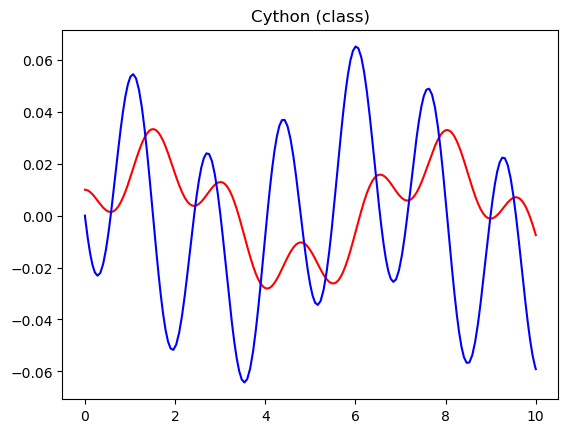

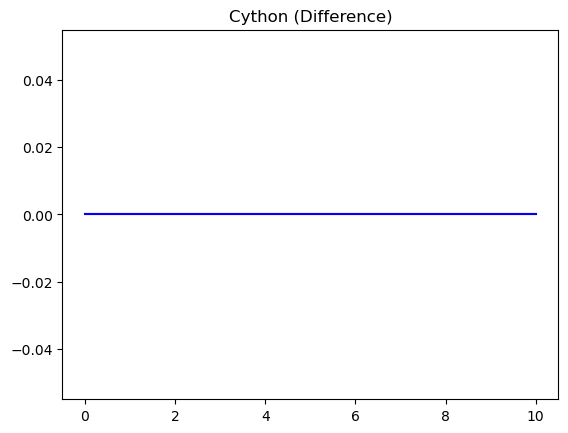

In [313]:
fig_cy_cl, ax_cy_cl = plt.subplots()
ax_cy_cl.plot(t_cy_cl, y_cy_cl[0], 'r')
ax_cy_cl.plot(t_cy_cl, y_cy_cl[1], 'b')
ax_cy_cl.set(title='Cython (class)')
plt.show()

fig_cy_cl_diff, ax_cy_cl_diff = plt.subplots()
if t_cy_cl.size != t_cy.size:
    print('SIZE MISMATCH')
    new_y1 = np.interp(t_cy, t_cy_cl, y_cy_cl[0])
    new_y2 = np.interp(t_cy, t_cy_cl, y_cy_cl[1])
else:
    new_y1 = y_cy_cl[0]
    new_y2 = y_cy_cl[1]
ax_cy_cl_diff.plot(t_cy, new_y1 - y_cy[0], 'r')
ax_cy_cl_diff.plot(t_cy, new_y2 - y_cy[1], 'b')
ax_cy_cl_diff.set(title='Cython (Difference)')
plt.show()

In [314]:
print('Performance')
print('Cython (class - solve only)')
# CyRK v0.6.0:
# 4.1ms, 4.03ms, 4.1ms
# 311us, 314us, 308us
# 300us, 298us, 300us
# 285us, 292us
# 295us
# 85.1us, 84.4us, 85us

Solver = PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1)
%timeit Solver.solve()

print('Cython (class - build)')
# CyRK v0.6.0:
# 21.1us, 20.9us, 20.9us
# 21us, 20.7us, 20.9us
# 22us, 21.8us, 21.4us
# 22us, 22.9us
# 22.6us, 23.1us, 22.8us

%timeit PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1)

print('Cython (class - build and solve)')
# CyRK v0.6.0:
# 4.08ms, 4.21ms, 4.09ms
# 329us. 335us, 324us
# 319us, 310us, 318us
# 306us, 303us
# 103us, 102us, 102us

%timeit PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1).solve()

Performance
Cython (class - solve only)
86.5 µs ± 1.11 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Cython (class - build)
22.6 µs ± 184 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Cython (class - build and solve)
104 µs ± 257 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [310]:
print('Expected Size Performance')

print('Default (1000)')
# 101us, 103us
A = PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1)
A.solve()
print('Growths', A.size_growths)
%timeit PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1).solve()

print('Way overshoot')
# 128us, 126us, 130us
A = PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, expected_size=100000)
A.solve()
print('Growths', A.size_growths)
%timeit PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, expected_size=100000).solve()

print('Nearly exactly whats needed')
# 108us, 109us
A = PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, expected_size=200)
A.solve()
print('Growths', A.size_growths)
%timeit PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, expected_size=200).solve()

print('undershoot once')
# 113us,
A = PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, expected_size=100)
A.solve()
print('Growths', A.size_growths)
%timeit PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, expected_size=100).solve()

print('undershoot 10x')
# 146us,
A = PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, expected_size=19)
A.solve()
print('Growths', A.size_growths)
%timeit PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, expected_size=19).solve()

print('undershoot max')
# 830us
A = PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, expected_size=1)
A.solve()
print('Growths', A.size_growths)
%timeit PendulumSolver(pendulum_time_span_1, pendulum_y0, pendulum_args, RTOL, ATOL, rk_method=1, expected_size=1).solve()


Expected Size Performance
Default (1000)
Growths 1
109 µs ± 1.38 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Way overshoot
Growths 1
130 µs ± 1.98 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Nearly exactly whats needed
Growths 1
109 µs ± 2.19 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
undershoot once
Growths 2
112 µs ± 941 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
undershoot 10x
Growths 10
146 µs ± 1.49 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
undershoot max
Growths 181
830 µs ± 6.49 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
